In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import corner

from cmcrameri import cm
from matplotlib.lines import Line2D
from matplotlib.colors import to_hex

from utils import (
    rcparams,
    to_GeV_per_cubic_femtometre,
    to_nucleons_per_cubic_femtometre,
)
plt.rcParams.update(rcparams)

In [2]:
collated_eos_path = [
    'collated_np_all_post.csv', 
    '/home/isaac.legred/PTAnalysis/Analysis/collated_np_all_post.csv'
    ][0]

eos_dir = ['eos-draws', '/home/philippe.landry/nseos/eos/gp/mrgagn'][0]

In [3]:
# Load the collated EOSs and filter out the ones with zero weight
collated_eos = pd.read_csv(collated_eos_path)
nonzero_collated_eos = collated_eos[collated_eos.logweight_total > -np.inf]

# The pre-computed weights of these EOSs
weights = np.exp(nonzero_collated_eos.logweight_total.values)

# The marginalised QCD weights
marg_weights = np.loadtxt('weights/qcd_weights_ntov_marg.dat')

In [4]:
len(weights), len(marg_weights)

(80162, 80162)

In [5]:
ntov_array = to_nucleons_per_cubic_femtometre(nonzero_collated_eos['rhoc(M@Mmax)'])

In [6]:
exclude_mask = ntov_array < 0.16*35

weights = weights[exclude_mask]
marg_weights = marg_weights[exclude_mask]

In [7]:
len(weights), len(marg_weights)

(80153, 80153)

In [8]:
pressure_at_ntov = np.loadtxt('ntov_quantities/pressure.dat')
energy_density_at_ntov = np.loadtxt('ntov_quantities/energy_density.dat')

Mmax = nonzero_collated_eos['Mmax'].values[exclude_mask]
Rmax = np.loadtxt('ntov_quantities/radius.dat')[exclude_mask]

In [9]:
len(pressure_at_ntov), len(energy_density_at_ntov), len(Mmax), len(Rmax)

(80153, 80153, 80153, 80153)

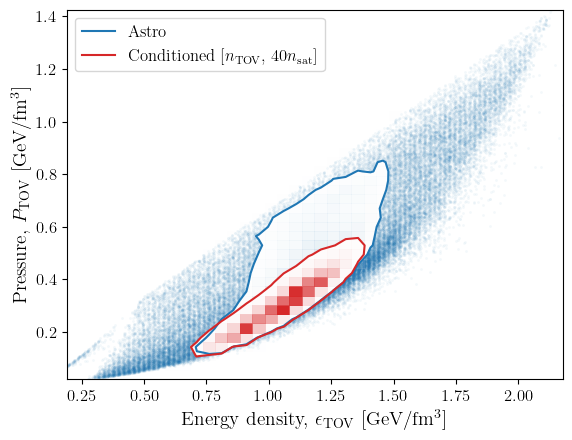

In [10]:
fig, ax = plt.subplots()

corner.hist2d(
    energy_density_at_ntov, 
    pressure_at_ntov, 
    ax=ax,
    weights=weights, 
    bins=40, 
    levels=[0.9],
    color='C0',
    data_kwargs={'alpha': 0.05},
    )

corner.hist2d(
    energy_density_at_ntov, 
    pressure_at_ntov, 
    ax=ax,
    weights=weights*marg_weights,
    bins=40, 
    levels=[0.9],
    color='C3',
    data_kwargs={'alpha': 0.},
    )

labels = [
    'Astro',
    'Conditioned [$n_\mathrm{TOV}$, $40n_\mathrm{sat}$]',
    ]

lines = [
    Line2D([0], [0], color='C0'),
    Line2D([0], [0], color='C3'),
    ]

ax.legend(lines, labels, loc='upper left')

ax.set_xlabel(r'Energy density, $\epsilon_\mathrm{TOV}$ [GeV/fm$^3$]')
_ = ax.set_ylabel(r'Pressure, $P_\mathrm{TOV}$ [GeV/fm$^3$]')

Text(0, 0.5, 'Mass, $M_\\mathrm{max}$ [$M_\\odot$]')

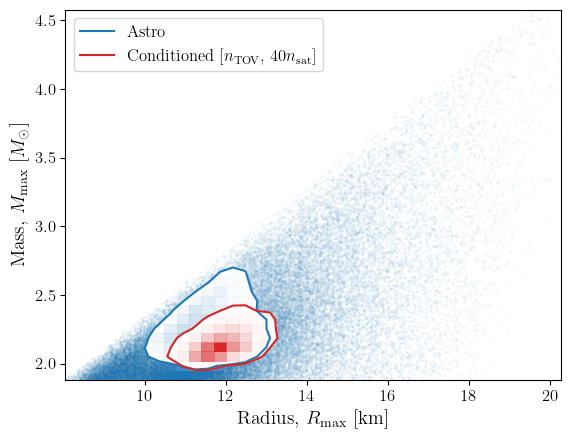

In [11]:
fig, ax = plt.subplots()

corner.hist2d(
    Rmax, 
    Mmax, 
    ax=ax,
    weights=weights, 
    bins=40, 
    levels=[0.9],
    color='C0',
    data_kwargs={'alpha': 0.05},
    )

corner.hist2d(
    Rmax, 
    Mmax, 
    ax=ax,
    weights=weights*marg_weights,
    bins=40, 
    levels=[0.9],
    color='C3',
    data_kwargs={'alpha': 0.},
    )

labels = [
    'Astro',
    'Conditioned [$n_\mathrm{TOV}$, $40n_\mathrm{sat}$]',
    ]

lines = [
    Line2D([0], [0], color='C0'),
    Line2D([0], [0], color='C3'),
    ]

ax.legend(lines, labels, loc='upper left')

ax.set_xlabel(r'Radius, $R_\mathrm{max}$ [km]')
ax.set_ylabel(r'Mass, $M_\mathrm{max}$ [$M_\odot$]')

Text(0, 0.5, 'Mass, Mmax')

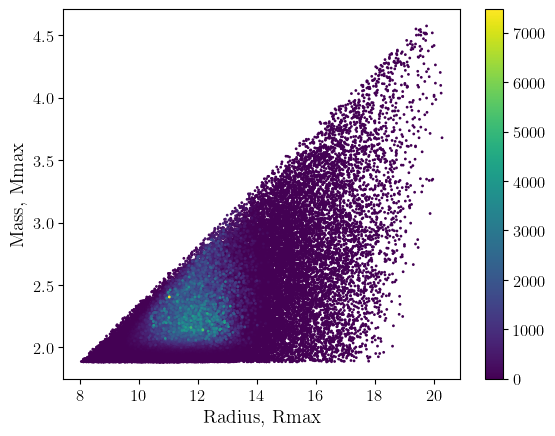

In [12]:
# Order Rmax and Mmax by weights
order = np.argsort(weights)

fig, ax = plt.subplots()

im = ax.scatter(Rmax[order], Mmax[order], c=weights[order], cmap='viridis', s=1)
fig.colorbar(im, ax=ax)

ax.set_xlabel('Radius, Rmax')
ax.set_ylabel('Mass, Mmax')


Text(0, 0.5, 'Mass, Mmax')

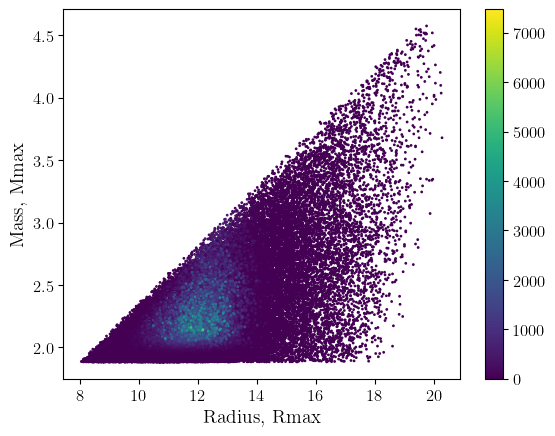

In [13]:
# Order Rmax and Mmax by weights
order = np.argsort(weights*marg_weights)

fig, ax = plt.subplots()

im = ax.scatter(Rmax[order], Mmax[order], c=weights[order], cmap='viridis', s=1)
fig.colorbar(im, ax=ax)

ax.set_xlabel('Radius, Rmax')
ax.set_ylabel('Mass, Mmax')


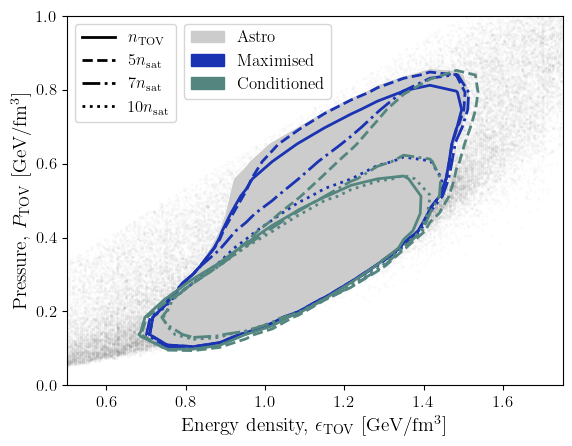

In [16]:
nterm_list = ['ntov', 'ns05', 'ns07', 'ns10']
methods = ['Xmarg', 'marg']

linestyles = ['-', '--', '-.', ':']

fig, ax = plt.subplots()

corner.hist2d(
    energy_density_at_ntov, 
    pressure_at_ntov, 
    ax=ax,
    weights=weights, 
    bins=30, 
    levels=[0.9],
    smooth=0.75,
    plot_datapoints=True,
    fill_contours=True,
    plot_density=False,
    no_fill_contours=False,
    data_kwargs={'alpha': 0.02},
    contour_kwargs={'linewidths': 0},
    contourf_kwargs={'alpha': 0.2, 'antialiased': True},
    )

for i, method in enumerate(methods):
    for j, nterm in enumerate(nterm_list):

        nterm_weights = np.loadtxt(f'weights/qcd_weights_{nterm}_{method}.dat')

        corner.hist2d(
            energy_density_at_ntov, 
            pressure_at_ntov, 
            ax=ax,
            weights=weights*nterm_weights[exclude_mask], 
            bins=30, 
            levels=[0.9],
            smooth=0.75,
            color=to_hex(cm.imola(i/len(methods))),
            plot_datapoints=False,
            fill_contours=False,
            no_fill_contours=True,
            plot_density=False,
            contour_kwargs={'linestyles': linestyles[j], 'linewidths': 2},
            )

l1 = ax.legend(
    [Line2D([0], [0], color='k', linestyle=linestyles[j], linewidth=2) for j in range(len(nterm_list))],
    ['$n_\mathrm{TOV}$', '$5n_\mathrm{sat}$', '$7n_\mathrm{sat}$', '$10n_\mathrm{sat}$'],
    loc='upper left',
)

ax.add_artist(l1)

l2 = ax.legend(
    [mpatches.Patch(color='#CCCCCC')] + [mpatches.Patch(color=to_hex(cm.imola(i/len(methods)))) for i in range(len(methods))],
    ['Astro', 'Maximised', 'Conditioned'],
    loc='upper left',
    bbox_to_anchor=(0.22, 1),
)

ax.set_xlim(0.5, 1.75)
ax.set_ylim(0, 1)

ax.set_xlabel(r'Energy density, $\epsilon_\mathrm{TOV}$ [GeV/fm$^3$]')
ax.set_ylabel(r'Pressure, $P_\mathrm{TOV}$ [GeV/fm$^3$]')

fig.savefig('figures/ptov_vs_epstov_comparison.pdf', bbox_inches='tight')

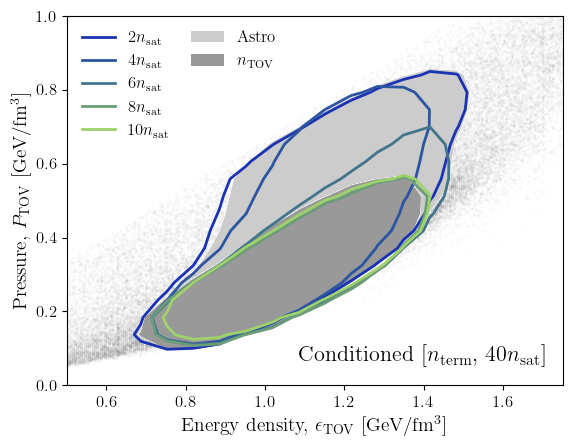

In [10]:
nterm_list = [2,4,6,8,10]
methods = ['Xmarg', 'marg']

linestyles = ['-', '--', '-.', ':']

fig, ax = plt.subplots()

corner.hist2d(
    energy_density_at_ntov, 
    pressure_at_ntov, 
    ax=ax,
    weights=weights, 
    bins=30, 
    levels=[0.9],
    smooth=0.75,
    plot_datapoints=True,
    fill_contours=True,
    plot_density=False,
    no_fill_contours=False,
    data_kwargs={'alpha': 0.02},
    contour_kwargs={'linewidths': 0},
    contourf_kwargs={'alpha': 0.2, 'antialiased': True},
    )

nterm_weights = np.loadtxt(f'weights/qcd_weights_ntov_marg.dat')

corner.hist2d(
    energy_density_at_ntov, 
    pressure_at_ntov, 
    ax=ax,
    weights=weights*nterm_weights[exclude_mask], 
    bins=30, 
    levels=[0.9],
    smooth=0.75,
    clor='k',
    plot_datapoints=False,
    fill_contours=True,
    plot_density=False,
    no_fill_contours=False,
    contour_kwargs={'linewidths': 0},
    contourf_kwargs={'alpha': 0.4, 'antialiased': True},
    )

for i, nterm in enumerate(nterm_list):

    nterm_weights = np.loadtxt(f'weights/qcd_weights_ns{nterm:02}_marg.dat')

    corner.hist2d(
        energy_density_at_ntov, 
        pressure_at_ntov, 
        ax=ax,
        weights=weights*nterm_weights[exclude_mask], 
        bins=30, 
        levels=[0.9],
        smooth=0.75,
        color=to_hex(cm.imola(i/len(nterm_list))),
        plot_datapoints=False,
        fill_contours=False,
        no_fill_contours=True,
        plot_density=False,
        contour_kwargs={'linestyles': '-', 'linewidths': 2},
        )

contours = [
    Line2D([0], [0], color=to_hex(cm.imola(i/len(nterm_list))), linestyle='-', linewidth=2) for i in range(len(nterm_list))
    ]
filled_contours = [mpatches.Patch(color='k', alpha=0.2, linewidth=0)] + [mpatches.Patch(color='k', alpha=0.4, linewidth=0)]

l1 = ax.legend(
    contours,
    [f'${nterm}n_\mathrm{{sat}}$' for nterm in nterm_list],
    loc='upper left',
    ncol=1,
    frameon=False
)

ax.add_artist(l1)

l2 = ax.legend(
    filled_contours,
    ['Astro', '$n_\mathrm{TOV}$'],
    loc='upper left',
    bbox_to_anchor=(0.22, 1),
    frameon=False
)

ax.text(0.97, 0.05, 'Conditioned [$n_\mathrm{term}$, $40n_\mathrm{sat}$]', transform=ax.transAxes, ha='right', va='bottom', fontsize=16)

ax.set_xlim(0.5, 1.75)
ax.set_ylim(0, 1)

ax.set_xlabel(r'Energy density, $\epsilon_\mathrm{TOV}$ [GeV/fm$^3$]')
ax.set_ylabel(r'Pressure, $P_\mathrm{TOV}$ [GeV/fm$^3$]')

fig.savefig('figures/ptov_vs_epstov_marg_comparison.pdf', bbox_inches='tight')

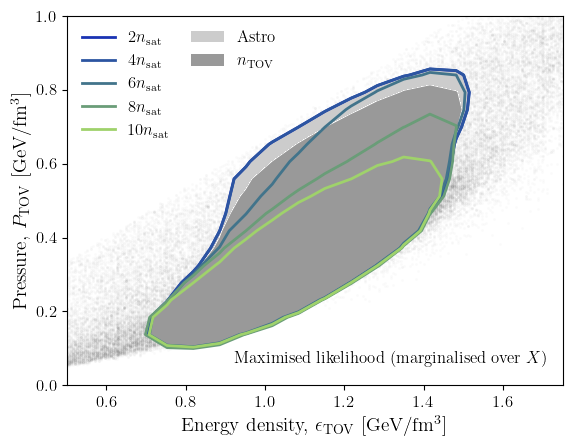

In [14]:
nterm_list = [2,4,6,8,10]
methods = ['Xmarg', 'marg']

linestyles = ['-', '--', '-.', ':']

fig, ax = plt.subplots()

corner.hist2d(
    energy_density_at_ntov, 
    pressure_at_ntov, 
    ax=ax,
    weights=weights, 
    bins=30, 
    levels=[0.9],
    smooth=0.75,
    plot_datapoints=True,
    fill_contours=True,
    plot_density=False,
    no_fill_contours=False,
    data_kwargs={'alpha': 0.02},
    contour_kwargs={'linewidths': 0},
    contourf_kwargs={'alpha': 0.2, 'antialiased': True},
    )

nterm_weights = np.loadtxt(f'weights/qcd_weights_ntov_Xmarg.dat')

corner.hist2d(
    energy_density_at_ntov, 
    pressure_at_ntov, 
    ax=ax,
    weights=weights*nterm_weights[exclude_mask], 
    bins=30, 
    levels=[0.9],
    smooth=0.75,
    clor='k',
    plot_datapoints=False,
    fill_contours=True,
    plot_density=False,
    no_fill_contours=False,
    contour_kwargs={'linewidths': 0},
    contourf_kwargs={'alpha': 0.4, 'antialiased': True},
    )

for i, nterm in enumerate(nterm_list):

    nterm_weights = np.loadtxt(f'weights/qcd_weights_ns{nterm:02}_Xmarg.dat')

    corner.hist2d(
        energy_density_at_ntov, 
        pressure_at_ntov, 
        ax=ax,
        weights=weights*nterm_weights[exclude_mask], 
        bins=30, 
        levels=[0.9],
        smooth=0.75,
        color=to_hex(cm.imola(i/len(nterm_list))),
        plot_datapoints=False,
        fill_contours=False,
        no_fill_contours=True,
        plot_density=False,
        contour_kwargs={'linestyles': '-', 'linewidths': 2},
        )

contours = [
    Line2D([0], [0], color=to_hex(cm.imola(i/len(nterm_list))), linestyle='-', linewidth=2) for i in range(len(nterm_list))
    ]
filled_contours = [mpatches.Patch(color='k', alpha=0.2, linewidth=0)] + [mpatches.Patch(color='k', alpha=0.4, linewidth=0)]

l1 = ax.legend(
    contours,
    [f'${nterm}n_\mathrm{{sat}}$' for nterm in nterm_list],
    loc='upper left',
    ncol=1,
    frameon=False
)

ax.add_artist(l1)

l2 = ax.legend(
    filled_contours,
    ['Astro', '$n_\mathrm{TOV}$'],
    loc='upper left',
    bbox_to_anchor=(0.22, 1),
    frameon=False
)

ax.text(0.97, 0.05, 'Maximised likelihood (marginalised over $X$)', transform=ax.transAxes, ha='right', va='bottom', fontsize=12)

ax.set_xlim(0.5, 1.75)
ax.set_ylim(0, 1)

ax.set_xlabel(r'Energy density, $\epsilon_\mathrm{TOV}$ [GeV/fm$^3$]')
ax.set_ylabel(r'Pressure, $P_\mathrm{TOV}$ [GeV/fm$^3$]')

fig.savefig('figures/ptov_vs_epstov_Xmarg_comparison.pdf', bbox_inches='tight')

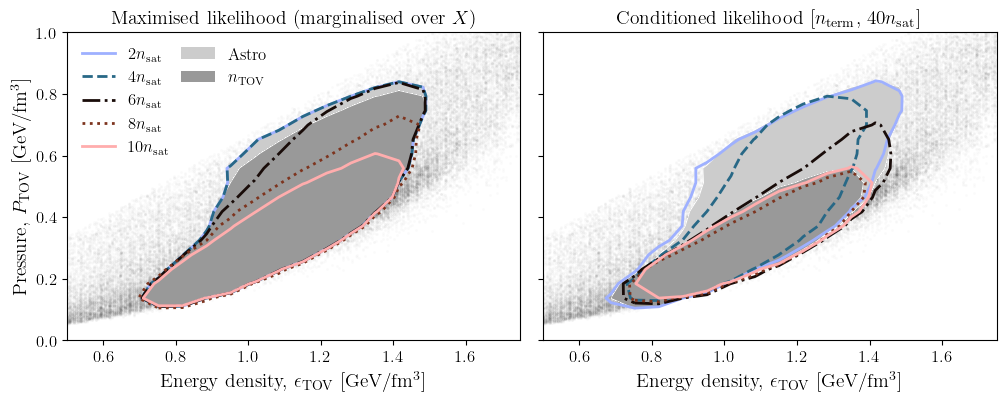

In [44]:
nterm_list = [2,4,6,8,10]
linestyles = ['-', '--', '-.', ':']
methods = ['Xmarg', 'marg']
titles = ['Maximised likelihood (marginalised over $X$)', 'Conditioned likelihood [$n_\mathrm{term}$, $40n_\mathrm{sat}$]']

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

fig.subplots_adjust(wspace=0.05)

for ax, method in zip(axs, methods):

    ax.set_title(titles[methods.index(method)])

    corner.hist2d(
        energy_density_at_ntov, 
        pressure_at_ntov, 
        ax=ax,
        weights=weights, 
        bins=30, 
        levels=[0.9],
        smooth=0.5,
        plot_datapoints=True,
        fill_contours=True,
        plot_density=False,
        no_fill_contours=False,
        data_kwargs={'alpha': 0.02},
        contour_kwargs={'linewidths': 0},
        contourf_kwargs={'alpha': 0.2, 'antialiased': True},
        )

    nterm_weights = np.loadtxt(f'weights/qcd_weights_ntov_{method}.dat')

    corner.hist2d(
        energy_density_at_ntov, 
        pressure_at_ntov, 
        ax=ax,
        weights=weights*nterm_weights[exclude_mask], 
        bins=30, 
        levels=[0.9],
        smooth=0.5,
        clor='k',
        plot_datapoints=False,
        fill_contours=True,
        plot_density=False,
        no_fill_contours=False,
        contour_kwargs={'linewidths': 0},
        contourf_kwargs={'alpha': 0.4, 'antialiased': True},
        )

    for i, nterm in enumerate(nterm_list):

        nterm_weights = np.loadtxt(f'weights/qcd_weights_ns{nterm:02}_{method}.dat')

        corner.hist2d(
            energy_density_at_ntov, 
            pressure_at_ntov, 
            ax=ax,
            weights=weights*nterm_weights[exclude_mask], 
            bins=30, 
            levels=[0.9],
            smooth=0.5,
            color=to_hex(cm.berlin(i/(len(nterm_list)-1))),
            plot_datapoints=False,
            fill_contours=False,
            no_fill_contours=True,
            plot_density=False,
            contour_kwargs={'linestyles': linestyles[i%4], 'linewidths': 2},
            )
        
    ax.set_xlim(0.5, 1.75)
    ax.set_ylim(0, 1)

    ax.set_xlabel(r'Energy density, $\epsilon_\mathrm{TOV}$ [GeV/fm$^3$]')

axs[0].set_ylabel(r'Pressure, $P_\mathrm{TOV}$ [GeV/fm$^3$]')

contours = [
    Line2D([0], [0], color=to_hex(cm.berlin(i/(len(nterm_list)-1))), linestyle=linestyles[i%4], linewidth=2) for i in range(len(nterm_list))
    ]
filled_contours = [mpatches.Patch(color='k', alpha=0.2, linewidth=0)] + [mpatches.Patch(color='k', alpha=0.4, linewidth=0)]

l1 = axs[0].legend(
    contours,
    [f'${nterm}n_\mathrm{{sat}}$' for nterm in nterm_list],
    loc='upper left',
    ncol=1,
    frameon=False
)

axs[0].add_artist(l1)

l2 = axs[0].legend(
    filled_contours,
    ['Astro', '$n_\mathrm{TOV}$'],
    loc='upper left',
    bbox_to_anchor=(0.22, 1),
    frameon=False
)

fig.savefig('figures/ptov_vs_epstov_Xmarg_marg_comparison.pdf', bbox_inches='tight')

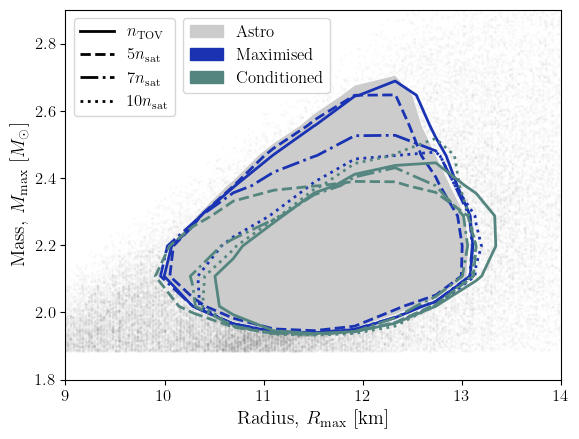

In [15]:
nterm_list = ['ntov', 'ns05', 'ns07', 'ns10']
methods = ['Xmarg', 'marg']

linestyles = ['-', '--', '-.', ':']

fig, ax = plt.subplots()

corner.hist2d(
    Rmax, 
    Mmax, 
    ax=ax,
    weights=weights, 
    bins=30, 
    levels=[0.9],
    smooth=0.4,
    plot_datapoints=True,
    fill_contours=True,
    plot_density=False,
    no_fill_contours=False,
    data_kwargs={'alpha': 0.02},
    contour_kwargs={'linewidths': 0},
    contourf_kwargs={'alpha': 0.2, 'antialiased': True},
    )

for i, method in enumerate(methods):
    for j, nterm in enumerate(nterm_list):

        nterm_weights = np.loadtxt(f'weights/qcd_weights_{nterm}_{method}.dat')

        corner.hist2d(
            Rmax, 
            Mmax, 
            ax=ax,
            weights=weights*nterm_weights[exclude_mask], 
            bins=30, 
            levels=[0.9],
            smooth=0.4,
            color=to_hex(cm.imola(i/len(methods))),
            plot_datapoints=False,
            fill_contours=False,
            no_fill_contours=True,
            plot_density=False,
            contour_kwargs={'linestyles': linestyles[j], 'linewidths': 2},
            )

l1 = ax.legend(
    [Line2D([0], [0], color='k', linestyle=linestyles[j], linewidth=2) for j in range(len(nterm_list))],
    ['$n_\mathrm{TOV}$', '$5n_\mathrm{sat}$', '$7n_\mathrm{sat}$', '$10n_\mathrm{sat}$'],
    loc='upper left',
)

ax.add_artist(l1)

l2 = ax.legend(
    [mpatches.Patch(color='#CCCCCC')] + [mpatches.Patch(color=to_hex(cm.imola(i/len(methods)))) for i in range(len(methods))],
    ['Astro', 'Maximised', 'Conditioned'],
    loc='upper left',
    bbox_to_anchor=(0.22, 1),
)

ax.set_xlim(9, 14)
ax.set_ylim(1.8, 2.9)

ax.set_xlabel(r'Radius, $R_\mathrm{max}$ [km]')
ax.set_ylabel(r'Mass, $M_\mathrm{max}$ [$M_\odot$]')

fig.savefig('figures/rmax_vs_mmax_comparison.pdf', bbox_inches='tight')

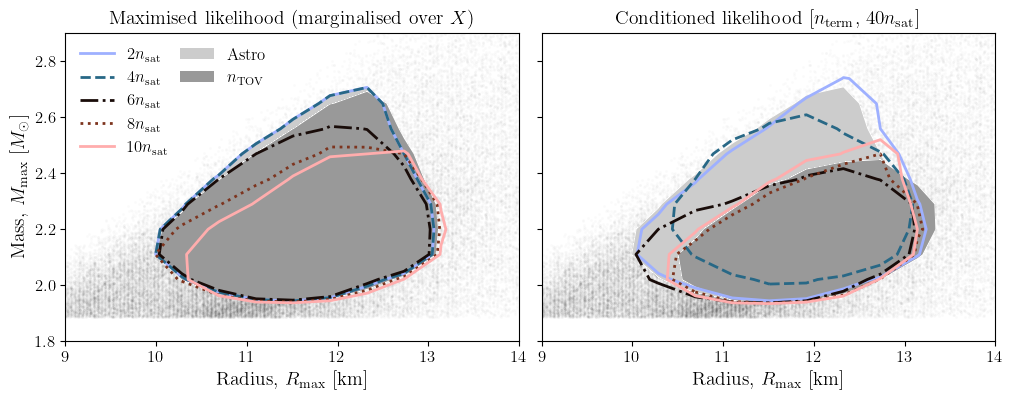

In [46]:
nterm_list = [2,4,6,8,10]
linestyles = ['-', '--', '-.', ':']
methods = ['Xmarg', 'marg']
titles = ['Maximised likelihood (marginalised over $X$)', 'Conditioned likelihood [$n_\mathrm{term}$, $40n_\mathrm{sat}$]']

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

fig.subplots_adjust(wspace=0.05)

for ax, method in zip(axs, methods):

    ax.set_title(titles[methods.index(method)])

    corner.hist2d(
        Rmax, 
        Mmax, 
        ax=ax,
        weights=weights, 
        bins=30, 
        levels=[0.9],
        smooth=0.4,
        plot_datapoints=True,
        fill_contours=True,
        plot_density=False,
        no_fill_contours=False,
        data_kwargs={'alpha': 0.02},
        contour_kwargs={'linewidths': 0},
        contourf_kwargs={'alpha': 0.2, 'antialiased': True},
        )

    nterm_weights = np.loadtxt(f'weights/qcd_weights_ntov_{method}.dat')

    corner.hist2d(
        Rmax, 
        Mmax, 
        ax=ax,
        weights=weights*nterm_weights[exclude_mask], 
        bins=30, 
        levels=[0.9],
        smooth=0.4,
        clor='k',
        plot_datapoints=False,
        fill_contours=True,
        plot_density=False,
        no_fill_contours=False,
        contour_kwargs={'linewidths': 0},
        contourf_kwargs={'alpha': 0.4, 'antialiased': True},
        )

    for i, nterm in enumerate(nterm_list):

        nterm_weights = np.loadtxt(f'weights/qcd_weights_ns{nterm:02}_{method}.dat')

        corner.hist2d(
            Rmax, 
            Mmax, 
            ax=ax,
            weights=weights*nterm_weights[exclude_mask], 
            bins=30, 
            levels=[0.9],
            smooth=0.4,
            color=to_hex(cm.berlin(i/(len(nterm_list)-1))),
            plot_datapoints=False,
            fill_contours=False,
            no_fill_contours=True,
            plot_density=False,
            contour_kwargs={'linestyles': linestyles[i%4], 'linewidths': 2},
            )
        
    ax.set_xlim(9, 14)
    ax.set_ylim(1.8, 2.9)

    ax.set_xlabel(r'Radius, $R_\mathrm{max}$ [km]')

axs[0].set_ylabel(r'Mass, $M_\mathrm{max}$ [$M_\odot$]')

contours = [
    Line2D([0], [0], color=to_hex(cm.berlin(i/(len(nterm_list)-1))), linestyle=linestyles[i%4], linewidth=2) for i in range(len(nterm_list))
    ]
filled_contours = [mpatches.Patch(color='k', alpha=0.2, linewidth=0)] + [mpatches.Patch(color='k', alpha=0.4, linewidth=0)]

l1 = axs[0].legend(
    contours,
    [f'${nterm}n_\mathrm{{sat}}$' for nterm in nterm_list],
    loc='upper left',
    ncol=1,
    frameon=False
)

axs[0].add_artist(l1)

l2 = axs[0].legend(
    filled_contours,
    ['Astro', '$n_\mathrm{TOV}$'],
    loc='upper left',
    bbox_to_anchor=(0.22, 1),
    frameon=False
)

fig.savefig('figures/rmax_vs_mmax_Xmarg_marg_comparison.pdf', bbox_inches='tight')